In [288]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on MNIST dataset

In [2]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms

mean, std = 0.28604059698879553, 0.35302424451492237
batch_size = 256

train_dataset = FashionMNIST('../data/FashionMNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = FashionMNIST('../data/FashionMNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))

cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

n_classes = 10

## Common setup

In [3]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
mnist_classes = fashion_mnist_classes

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Baseline: Classification with softmax
We'll train the model for classification and use outputs of penultimate layer as embeddings

In [11]:
# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, ClassificationNet
from metrics import AccumulatedAccuracyMetric

embedding_net = EmbeddingNet()
model = ClassificationNet(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 3
log_interval = 50

In [12]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

Train: [0/60000 (0%)]	Loss: 2.349608	Accuracy: 9.765625
Train: [12800/60000 (21%)]	Loss: 3.043674	Accuracy: 8.678002450980392
Train: [25600/60000 (43%)]	Loss: 1.963417	Accuracy: 15.710086633663366
Train: [38400/60000 (64%)]	Loss: 1.561169	Accuracy: 22.294081125827816
Train: [51200/60000 (85%)]	Loss: 1.251706	Accuracy: 29.872123756218905
Epoch: 1/3. Train set: Average loss: 1.8094	Accuracy: 35.251666666666665
Epoch: 1/3. Validation set: Average loss: 0.8940	Accuracy: 67.8
Train: [0/60000 (0%)]	Loss: 0.788522	Accuracy: 73.828125
Train: [12800/60000 (21%)]	Loss: 0.814609	Accuracy: 71.89031862745098
Train: [25600/60000 (43%)]	Loss: 0.727411	Accuracy: 73.29439975247524
Train: [38400/60000 (64%)]	Loss: 0.662475	Accuracy: 74.16442466887418
Train: [51200/60000 (85%)]	Loss: 0.601634	Accuracy: 75.07773631840796
Epoch: 2/3. Train set: Average loss: 0.6871	Accuracy: 75.505
Epoch: 2/3. Validation set: Average loss: 0.5979	Accuracy: 77.83
Train: [0/60000 (0%)]	Loss: 0.462399	Accuracy: 82.421875
Trai

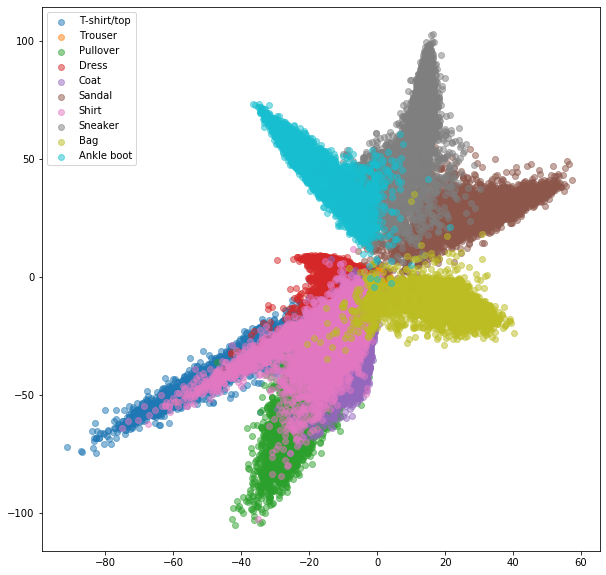

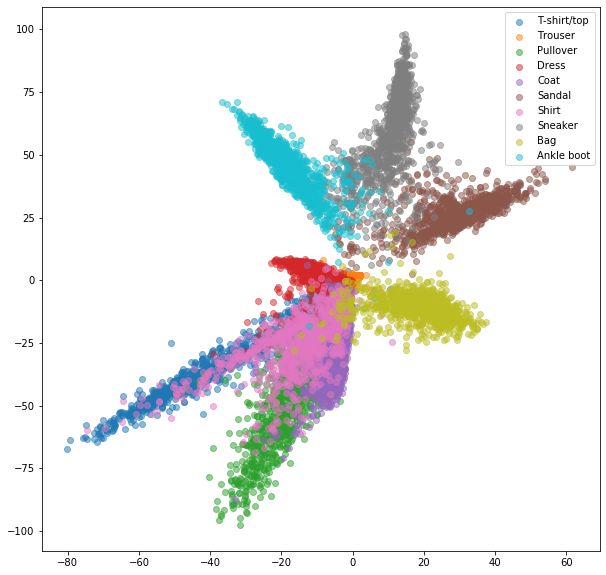

In [13]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

In [15]:
for images, target in train_loader:
    print(images, target)

tensor([[[[-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          [-0.8103, -0.8103, -0.7991,  ..., -0.8103, -0.8103, -0.8103],
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          ...,
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103]]],


        [[[-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          ...,
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103]]],


        [[[-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          [-0.8103, -0.810

In [14]:
train_embeddings_baseline, train_labels_baseline

(array([[ 10.17071915,  65.79110718],
        [ -8.28289986, -24.16333199],
        [-26.08703804, -24.88628197],
        ...,
        [  0.47680628,   1.72813213],
        [ -3.99553204,  -2.47856641],
        [  1.5438447 ,  23.24027443]]), array([7., 6., 3., ..., 1., 6., 9.]))

# Siamese network
We'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

## Steps
1. Create a dataset returning pairs - **SiameseMNIST** class from *datasets.py*, wrapper for MNIST-like classes.
2. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
3. Define **siamese** network processing pairs of inputs - **SiameseNet** wrapping *EmbeddingNet*
4. Train the network with **ContrastiveLoss** - *losses.py*

In [291]:
# Set up data loaders
from datasets import SiameseMNIST

# Step 1
siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

# Step 2
embedding_net = EmbeddingNet()
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
optimizer = optim.Adam(model.parameters(), lr=lr)
n_epochs = 2
log_interval = 500

In [292]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.265764
Epoch: 1/2. Train set: Average loss: 0.0493
Epoch: 1/2. Validation set: Average loss: 0.0445
Train: [0/60000 (0%)]	Loss: 0.059977
Epoch: 2/2. Train set: Average loss: 0.0376
Epoch: 2/2. Validation set: Average loss: 0.0377


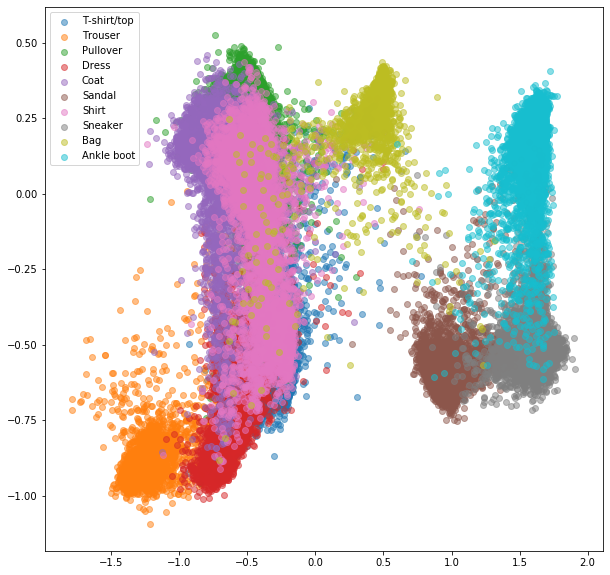

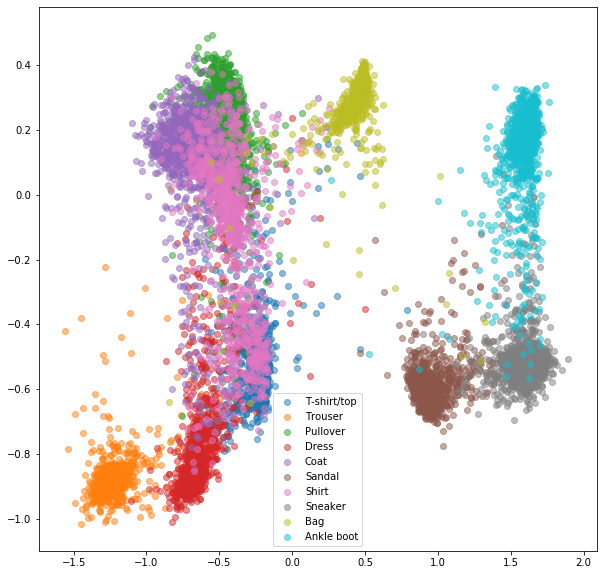

In [293]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

In [296]:
siamese_train_dataset[0]

((tensor([[[-8.1026e-01, -8.1026e-01, -8.1026e-01, -8.1026e-01, -8.1026e-01,
            -8.1026e-01, -8.1026e-01, -8.1026e-01, -8.1026e-01, -8.1026e-01,
            -8.1026e-01, -8.1026e-01, -8.1026e-01, -8.1026e-01, -8.1026e-01,
            -8.1026e-01, -8.1026e-01, -8.1026e-01, -8.1026e-01, -8.1026e-01,
            -8.1026e-01, -8.1026e-01, -8.1026e-01, -8.1026e-01, -8.1026e-01,
            -8.1026e-01, -8.1026e-01, -8.1026e-01],
           [-8.1026e-01, -8.1026e-01, -8.1026e-01, -8.1026e-01, -8.1026e-01,
            -8.1026e-01, -8.1026e-01, -8.1026e-01, -8.1026e-01, -8.1026e-01,
            -8.1026e-01, -8.1026e-01, -8.1026e-01, -8.1026e-01, -8.1026e-01,
            -8.1026e-01, -8.1026e-01, -8.1026e-01, -8.1026e-01, -8.1026e-01,
            -8.1026e-01, -8.1026e-01, -8.1026e-01, -8.1026e-01, -8.1026e-01,
            -8.1026e-01, -8.1026e-01, -8.1026e-01],
           [-8.1026e-01, -8.1026e-01, -8.1026e-01, -8.1026e-01, -8.1026e-01,
            -8.1026e-01, -8.1026e-01, -8.1026e-01

# Project Unseen Class

Goal is to interpret the projection of an unseen class across the learned topology of metric space defined by other classes.

## Steps
1. Create a dataset returning pairs - **SiameseMNIST** class from *datasets.py*, wrapper for MNIST-like classes, with ability to remove class of interest.
2. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
3. Define **siamese** network processing pairs of inputs - **SiameseNet** wrapping *EmbeddingNet*
4. Train the network with **ContrastiveLoss** - *losses.py*
5. Feed left out class into network to understand relative projection.

In [272]:
mnist_classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [273]:
import numpy as np
from PIL import Image

from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler


class SiameseMNIST_ablate(Dataset):
    """
    Train: For each sample creates randomly a positive or a negative pair
    Test: Creates fixed pairs for testing
    """

    def __init__(self, mnist_dataset, ablate_classes):
        self.classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
        self.class_index = [self.classes.index(cat) for cat in ablate_classes]
        
        self.mnist_dataset = mnist_dataset

        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.remove_indices = [np.where(self.mnist_dataset.train_labels == i)[0] for i in self.class_index]
            self.train_labels = np.delete(self.mnist_dataset.train_labels, self.remove_indices)
            self.train_data = np.delete(self.mnist_dataset.train_data, self.remove_indices, axis=0)
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}
        else:
            # generate fixed pairs for testing
            self.remove_indices = [np.where(self.mnist_dataset.test_labels == i)[0] for i in self.class_index]
            self.test_labels = np.delete(self.mnist_dataset.test_labels, self.remove_indices)
            self.test_data = np.delete(self.mnist_dataset.test_data, self.remove_indices, axis=0)
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                               1]
                              for i in range(0, len(self.test_data), 2)]

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.test_labels[i].item()]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.test_data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

    def __getitem__(self, index):
        if self.train:
            target = np.random.randint(0, 2)
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            if target == 1:
                siamese_index = index
                while siamese_index == index:
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else:
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.train_data[siamese_index]
        else:
            img1 = self.test_data[self.test_pairs[index][0]]
            img2 = self.test_data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]

        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return (img1, img2), target

    def __len__(self):
        return len(self.mnist_dataset) - len(np.concatenate(self.remove_indices).ravel())

In [279]:
# Set up data loaders

# Step 1
ablate = ['Ankle boot', 'Sneaker', 'Sandal']
siamese_train_dataset = SiameseMNIST_ablate(train_dataset, ablate) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST_ablate(test_dataset, ablate)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

# Step 2
embedding_net = EmbeddingNet()
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
optimizer = optim.Adam(model.parameters(), lr=lr)
n_epochs = 1
log_interval = 500

In [280]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/42000 (0%)]	Loss: 0.239182
Epoch: 1/1. Train set: Average loss: 0.0699
Epoch: 1/1. Validation set: Average loss: 0.0579


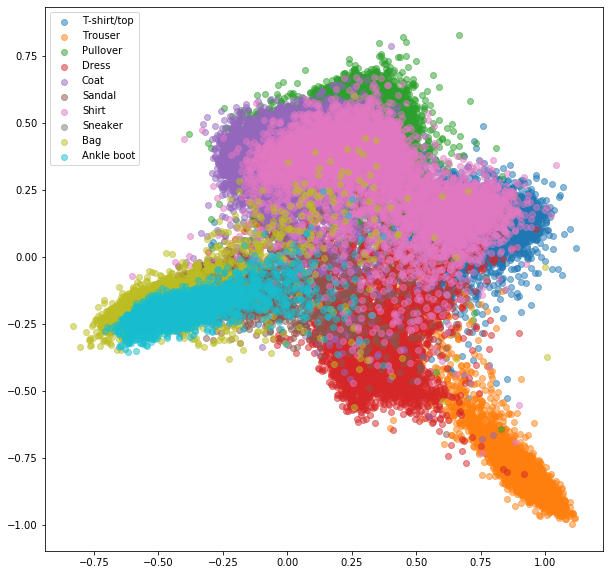

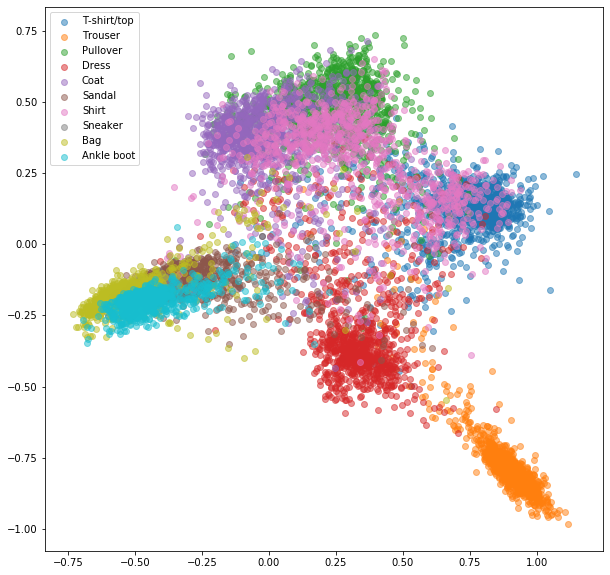

In [281]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

In [282]:
n_epochs = 10
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/42000 (0%)]	Loss: 0.063168
Epoch: 1/10. Train set: Average loss: 0.0539
Epoch: 1/10. Validation set: Average loss: 0.0564
Train: [0/42000 (0%)]	Loss: 0.051657
Epoch: 2/10. Train set: Average loss: 0.0470
Epoch: 2/10. Validation set: Average loss: 0.0497
Train: [0/42000 (0%)]	Loss: 0.045382
Epoch: 3/10. Train set: Average loss: 0.0425
Epoch: 3/10. Validation set: Average loss: 0.0480
Train: [0/42000 (0%)]	Loss: 0.046444
Epoch: 4/10. Train set: Average loss: 0.0387
Epoch: 4/10. Validation set: Average loss: 0.0460
Train: [0/42000 (0%)]	Loss: 0.038793
Epoch: 5/10. Train set: Average loss: 0.0364
Epoch: 5/10. Validation set: Average loss: 0.0431
Train: [0/42000 (0%)]	Loss: 0.028484
Epoch: 6/10. Train set: Average loss: 0.0345
Epoch: 6/10. Validation set: Average loss: 0.0433
Train: [0/42000 (0%)]	Loss: 0.035928
Epoch: 7/10. Train set: Average loss: 0.0320
Epoch: 7/10. Validation set: Average loss: 0.0441
Train: [0/42000 (0%)]	Loss: 0.025392
Epoch: 8/10. Train set: Average loss: 0

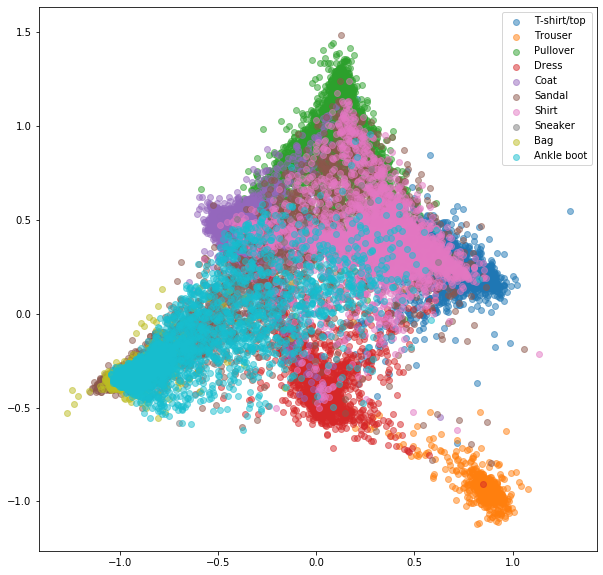

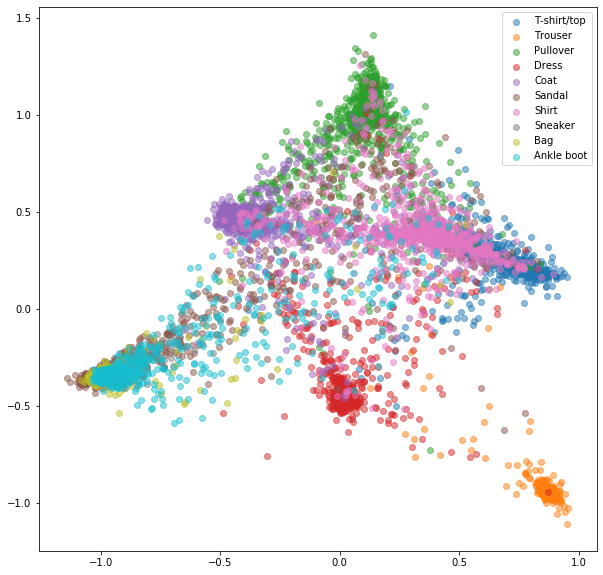

In [283]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

In [284]:
# Set up data loaders

# Step 1
ablate = ['Ankle boot']
siamese_train_dataset = SiameseMNIST_ablate(train_dataset, ablate) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST_ablate(test_dataset, ablate)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

# Step 2
embedding_net = EmbeddingNet()
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
optimizer = optim.Adam(model.parameters(), lr=lr)
n_epochs = 10
log_interval = 500

In [285]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/54000 (0%)]	Loss: 0.240824
Epoch: 1/10. Train set: Average loss: 0.0531
Epoch: 1/10. Validation set: Average loss: 0.0476
Train: [0/54000 (0%)]	Loss: 0.038180
Epoch: 2/10. Train set: Average loss: 0.0402
Epoch: 2/10. Validation set: Average loss: 0.0397
Train: [0/54000 (0%)]	Loss: 0.048080
Epoch: 3/10. Train set: Average loss: 0.0353
Epoch: 3/10. Validation set: Average loss: 0.0369
Train: [0/54000 (0%)]	Loss: 0.034616
Epoch: 4/10. Train set: Average loss: 0.0306
Epoch: 4/10. Validation set: Average loss: 0.0342
Train: [0/54000 (0%)]	Loss: 0.025233
Epoch: 5/10. Train set: Average loss: 0.0285
Epoch: 5/10. Validation set: Average loss: 0.0334
Train: [0/54000 (0%)]	Loss: 0.020670
Epoch: 6/10. Train set: Average loss: 0.0261
Epoch: 6/10. Validation set: Average loss: 0.0332
Train: [0/54000 (0%)]	Loss: 0.023678
Epoch: 7/10. Train set: Average loss: 0.0244
Epoch: 7/10. Validation set: Average loss: 0.0339
Train: [0/54000 (0%)]	Loss: 0.017933
Epoch: 8/10. Train set: Average loss: 0

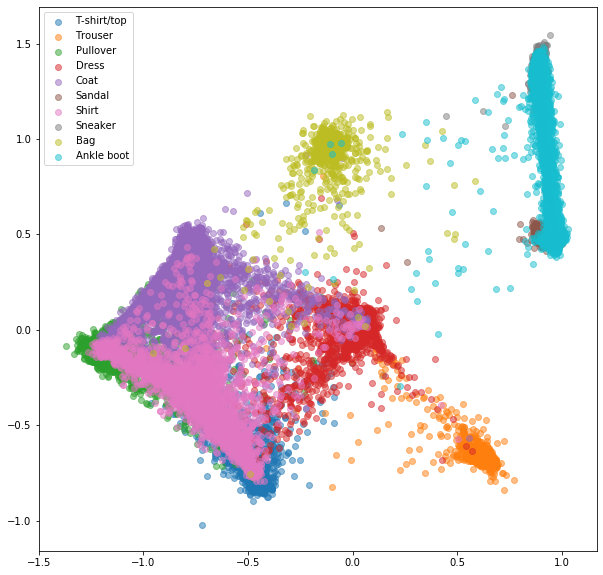

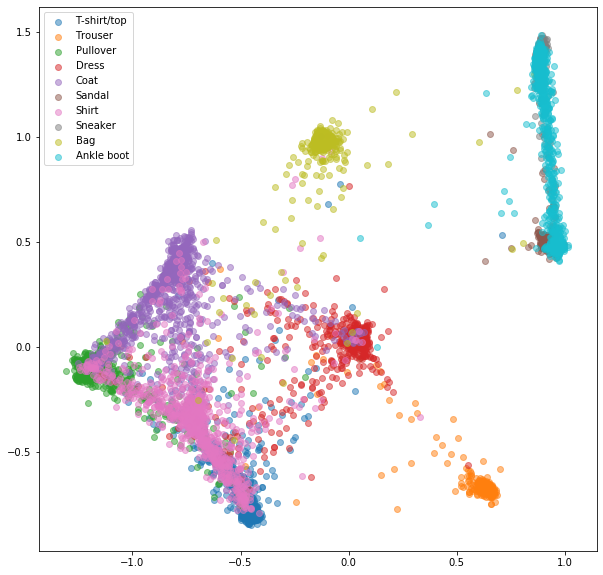

In [286]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

In [287]:
train_labels_cl

array([4., 2., 7., ..., 8., 3., 6.])